In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize
import sys
#from mpl_toolkits.basemap import Basemap
from collections import Counter
from sklearn.linear_model import LinearRegression
sys.path.append('/Users/hawbecke/Code/Python/')
from mmctools.helper_functions import calc_uv
from mmctools.helper_functions import calc_wind
from mmctools.wrf.utils import Tower, tsout_seriesReader
from pydicts.obsdict import read_AWOS, AWOS_to_ds
from pydicts.baybreezedict import DetectBayBreeze, spatial_breeze_check, find_onshore_minmax
#import pygrib

from cfgrib.xarray_store import open_dataset
#from sklearn.linear_model import LinearRegression
#import skimage.morphology

from datetime import date


In [4]:
obs_dir = '/Users/hawbecke/Research/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))

# Add APG data into AWOS
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})
non_apg_list = apg_stn_list.copy()
non_apg_list.remove('APG')
apg_ds = apg_ds.drop_sel(station=non_apg_list)
apg_ds = apg_ds.drop(['rh','gust','radt','rain','alt'])

temp = awos_ds.sel(station='APG').combine_first(apg_ds)
temp = temp.squeeze()
temp = temp.expand_dims('station')

lat_da = xr.DataArray([float(apg_ds.lat)], dims=('station'))
lon_da = xr.DataArray([float(apg_ds.lon)], dims=('station'))

temp = temp.assign_coords({'lat':lat_da})
temp = temp.assign_coords({'lon':lon_da})

awos_ds = awos_ds.drop_sel(station=['APG'])

awos_ds = xr.merge([awos_ds,temp])

near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']

# HRRR

In [5]:
hrrr_dir = '/Users/hawbecke/Research/Chesapeake/Data/HRRR/'
hrrr_files = sorted(glob.glob('{}forecast/hrrr.*.nc'.format(hrrr_dir)))
#hrrr_files = sorted(glob.glob('{}te*.nc'.format(hrrr_dir)))

#### Convert grib2 files with:

    ncl 'fname="hrrr.t16z.wrfsfcf00"' grib2ncdf.ncl

In [6]:
hrrrMD = xr.open_dataset(hrrr_files[0])
land_mask  = np.squeeze(hrrrMD.LAND_P0_L1_GLC0)
hgt        = np.squeeze(hrrrMD.HGT_P0_L1_GLC0)
water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
lat  = hrrrMD.gridlat_0
lon  = hrrrMD.gridlon_0

In [7]:
stn_dict = {}
for ss,stn in enumerate(near_shore_stations):
    stn_dict[stn] = {}
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    if land_mask.sel(ygrid_0=stn_j,xgrid_0=stn_i) == 0.0:
        if stn == 'NAK':
            stn_i -=1
        elif stn == 'NHK':
            stn_j -= 1
    stn_dict[stn]['lat'] = float(stn_ds.lat.data)
    stn_dict[stn]['lon'] = float(stn_ds.lon.data)
    stn_dict[stn]['i'] = stn_i
    stn_dict[stn]['j'] = stn_j


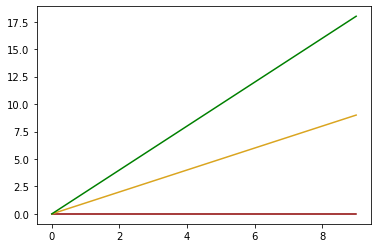

In [8]:
breeze_cmap = plt.cm.RdYlGn(np.linspace(0.1,0.9,3))
breeze_cmap = ['darkred','goldenrod','green']
#breeze_cmap = [[0.0, 0.0, 0.0, 1.0]]
#for ll,lvl in enumerate(np.arange(0,2)):
#    breeze_cmap = np.append(breeze_cmap,[list(breeze_cmap_f[ll])],axis=0)
#breeze_cmap = np.append(breeze_cmap,[[1.0, 0.0, 0.0, 1.0]],axis=0)
for ll,lvl in enumerate(np.arange(0,3)):
    plt.plot(np.arange(0,10),np.arange(0,10)*ll,c=breeze_cmap[ll])

In [9]:
onshore_min_max_path = '{}HRRR_onshore_min_max.nc'.format(hrrr_dir)
if path.exists(onshore_min_max_path):
    print('loading in onshore min/max dataset!')
    onshore_min_max_ds = xr.open_dataset(onshore_min_max_path)
    onshore_min = onshore_min_max_ds.onshore_min
    onshore_max = onshore_min_max_ds.onshore_max
else:


    onshore_min_max_ds = find_onshore_minmax(land_mask,
                                             max_water_dist = 110.0,
                                             low_pct_0 = 90.0,
                                             upr_pct_0 = 10.0,
                                             max_deg_range = 350.0,
                                             test_mode = False,
                                             min_water_size=20)
    onshore_min = onshore_min_max_ds.onshore_min
    onshore_max = onshore_min_max_ds.onshore_max
    onshore_min_max_ds.to_netcdf(onshore_min_max_path)

loading in onshore min/max dataset!


-31.813854 35.483112
165.49605 352.87497


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


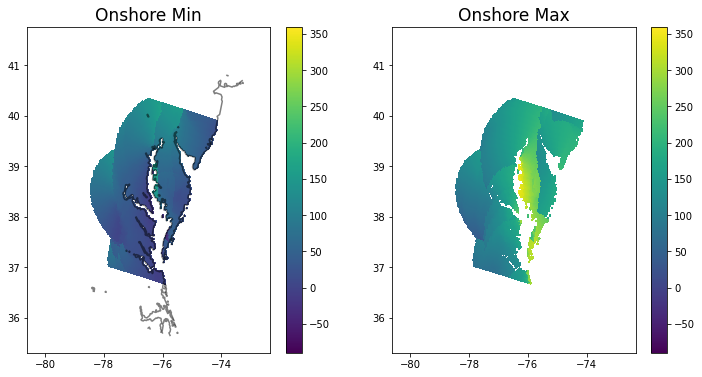

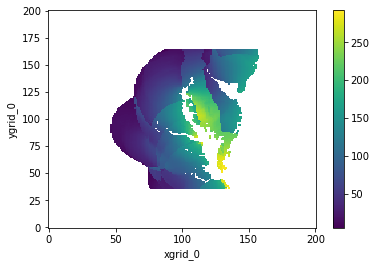

In [10]:
print(np.nanmin(onshore_min),np.nanmin(onshore_max))
print(np.nanmax(onshore_min),np.nanmax(onshore_max))
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
dist_plt = ax[0].pcolormesh(lon,lat,onshore_min,norm=Normalize(-90,360),cmap=plt.cm.viridis)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ax[0].set_title('Onshore Min',size=17)
deg_plt = ax[1].pcolormesh(lon,lat,onshore_max,norm=Normalize(-90,360),cmap=plt.cm.viridis)
plt.colorbar(deg_plt,ax=ax[1])
#ax[1].contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ax[1].set_title('Onshore Max',size=17)
plt.show()
(onshore_max - onshore_min).plot()
plt.show()

In [13]:
show_plot = False

check_clouds = True
check_rain   = True

hrrr_types = ['analysis','forecast']
for hrrr_type in hrrr_types:
    init_vars = True

    hrrr_files = sorted(glob.glob('{}{}/hrrr.*.nc'.format(hrrr_dir,hrrr_type)))

    if hrrr_type == 'forecast':
        hrrr_detection_file = '{}/forecast/spatial_breeze_detection_HRRR_CLDnRAIN_abs.nc'.format(hrrr_dir)
    else:
        hrrr_detection_file = '{}/analysis/spatial_breeze_detection_HRRR_CLDnRAIN_abs.nc'.format(hrrr_dir)

    if path.exists(hrrr_detection_file):
        print('loading in HRRR dataset!')
        breeze_ds_f = xr.open_dataset(hrrr_detection_file)
    else:
        for ww,hrrrout_file in enumerate(hrrr_files):
            print(hrrrout_file)
            hrrrMD = xr.open_dataset(hrrrout_file)

            out_time = pd.to_datetime(hrrrMD.TMP_P0_L103_GLC0.initial_time,format='%m/%d/%Y (%H:%M)')

            if hrrr_type == 'forecast':
                out_time += pd.to_timedelta(hrrrMD.TMP_P0_L103_GLC0.forecast_time,'h')
            if (out_time.hour >=13) & (out_time.hour <=22):
                time_str = date.strftime(out_time,'%Y-%m-%d %H:%M')
                print(time_str)
                if init_vars:
                    land_mask  = np.squeeze(hrrrMD.LAND_P0_L1_GLC0)
                    hgt        = np.squeeze(hrrrMD.HGT_P0_L1_GLC0)
                    water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
                    lat  = hrrrMD.gridlat_0
                    lon  = hrrrMD.gridlon_0
                onshore_min = onshore_min_max_ds.onshore_min
                onshore_max = onshore_min_max_ds.onshore_max

                breeze_ds = spatial_breeze_check(onshore_min,
                                                 onshore_max,
                                                 hrrrMD,
                                                 land_mask=land_mask,
                                                 wdir_check='vertical',
                                                 dT_cutoff_pct=40.0,
                                                 model='HRRR',
                                                 check_clouds=check_clouds,
                                                 check_rain=check_rain,
                                                 cloud_cutoff=0.6
                                                 )

                if init_vars:
                    breeze_ds_f = breeze_ds.copy()
                    init_vars = False
                else:
                    breeze_ds_f = breeze_ds.combine_first(breeze_ds_f) 



                if show_plot:
                    t2   = hrrrMD.POT_P0_L103_GLC0.where(land_mask == 1.0)
                    u10  = hrrrMD.UGRD_P0_L103_GLC0.sel(lv_HTGL2=10.0)
                    v10  = hrrrMD.VGRD_P0_L103_GLC0.sel(lv_HTGL2=10.0)
                    vel10 = (u10**2 + v10**2)**0.5
                    dir10 = 180. + np.degrees(np.arctan2(u10, v10))
                    vel10 = vel10.where(land_mask == 1.0)
                    dir10 = dir10.where(land_mask == 1.0)

                    fig = plt.figure(figsize=(16,20))
                    nrow,ncol = 4,4
                    dT_lvl = np.nanmax(abs(breeze_ds.dT_full.sel(datetime=time_str)))
                    tmp_plt = plt.subplot2grid((nrow,ncol),(0,0),colspan=2,aspect='equal')
                    tmp_plt_pc = tmp_plt.pcolormesh(lon,lat,breeze_ds.dT_full.sel(datetime=time_str),
                                                    cmap=plt.cm.RdYlBu,norm=Normalize(-dT_lvl,dT_lvl))
                    tmp_cbar = plt.colorbar(tmp_plt_pc,ax=tmp_plt)
                    tmp_cbar.ax.tick_params(labelsize=13)
                    tmp_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                    tmp_plt.contour(lon,lat,breeze_ds.dT.sel(datetime=time_str),levels=[breeze_ds.dT_cutoff],colors='limegreen')
                    tmp_plt.tick_params(labelsize=15,labelbottom=False)
                    tmp_plt.set_title('T2',size=18)


                    vel_plt = plt.subplot2grid((nrow,ncol),(1,0),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                    vel_plt_pc = vel_plt.pcolormesh(lon,lat,vel10,cmap=plt.cm.YlOrRd)
                    vel_cbar = plt.colorbar(vel_plt_pc,ax=vel_plt)
                    vel_cbar.ax.tick_params(labelsize=13)
                    vel_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                    vel_plt.contour(lon,lat,breeze_ds.dU.sel(datetime=time_str),levels=[0.5],colors='b')
                    vel_plt.tick_params(labelsize=15)
                    vel_plt.set_title('Wind Speed',size=18)

                    ons_plt = plt.subplot2grid((nrow,ncol),(0,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                    ons_plt_pc = ons_plt.pcolormesh(lon,lat,onshore_min,cmap=plt.cm.viridis,norm=Normalize(0,360))
                    ons_cbar = plt.colorbar(ons_plt_pc,ax=ons_plt)
                    ons_cbar.ax.tick_params(labelsize=13)
                    ons_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                    ons_plt.tick_params(labelsize=15,labelbottom=False)
                    ons_plt.set_title('Onshore Min',size=18)

                    dir_plt = plt.subplot2grid((nrow,ncol),(1,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                    dir_plt_pc = dir_plt.pcolormesh(lon,lat,dir10,cmap=plt.cm.viridis,norm=Normalize(0,360))
                    dir_cbar = plt.colorbar(dir_plt_pc,ax=dir_plt)
                    dir_cbar.ax.tick_params(labelsize=13)
                    dir_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                    qint = 7
                    dir_plt.quiver(lon[::qint,::qint],lat[::qint,::qint],u10[::qint,::qint],v10[::qint,::qint])
                    #dir_plt.contour(lon,lat,onshore_winds,levels=[1.0],colors='r')
                    dir_plt.contour(lon,lat,breeze_ds.good_wdir.sel(datetime=time_str),levels=[1.0],colors='r')
                    dir_plt.tick_params(labelsize=15)
                    dir_plt.set_title('Wind Direction',size=18)


                    crt_plt = plt.subplot2grid((nrow,ncol),(2,0),rowspan=2,colspan=4,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                    crt_plt_pc = crt_plt.pcolormesh(lon,lat,land_mask,cmap=plt.cm.binary,norm=Normalize(0,5.0))
                    #plt.colorbar(crt_plt_pc,ax=crt_plt)
                    crt_plt.contour(lon,lat,breeze_ds.good_wdir.sel(datetime=time_str),levels=[1.0],colors='r',alpha=0.5)
                    crt_plt.contour(lon,lat,breeze_ds.dT.sel(datetime=time_str),levels=[breeze_ds.dT_cutoff],colors='limegreen',alpha=0.5)
                    crt_plt.contour(lon,lat,breeze_ds.dU.sel(datetime=time_str),levels=[0.5],colors='b',alpha=0.5)
                    crt_plt.plot(0.0,0.0,c='r',label='Wind Direction')
                    crt_plt.plot(0.0,0.0,c='limegreen',label='∆T > 0')
                    crt_plt.plot(0.0,0.0,c='b',label='Wind Ramp')
                    crt_plt.set_xlim(np.nanmin(lon),np.nanmax(lon))
                    crt_plt.set_ylim(np.nanmin(lat),np.nanmax(lat))
                    good_areas = crt_plt.contourf(lon,lat,breeze_ds.breeze.sel(datetime=time_str),levels=[1.9,4.1],colors='k',
                                                  alpha=0.25,hatches=['+++', '/'],label='Test')
                    artists, labels = good_areas.legend_elements()
                    #crt_plt.legend(artists, ['Good Points'], handleheight=2)
                    crt_plt.legend(frameon=False,fontsize=18,loc=4)
                    crt_plt.tick_params(labelsize=15)
                    crt_plt.set_title(time_str,size=18)



                    if check_clouds: crt_plt.contour(lon,lat,breeze_ds.is_cloudy.sel(datetime=time_str),levels=[0.5],colors='m')

                    if check_rain: crt_plt.contour(lon,lat,breeze_ds.is_raining.sel(datetime=time_str),levels=[0.5],colors='c')


                    for ss,stn in enumerate(near_shore_stations):
                        stn_color = int(breeze_ds.breeze.sel(datetime=time_str,
                                                           ygrid_0=stn_dict[stn]['j'],
                                                           xgrid_0=stn_dict[stn]['i']).data)
                        crt_plt.scatter(stn_dict[stn]['lon'],stn_dict[stn]['lat'],
                                    facecolor=breeze_cmap[stn_color],s=100,
                                    edgecolor='k',zorder=4,alpha=0.65)
                        crt_plt.text(stn_dict[stn]['lon']-0.1,stn_dict[stn]['lat'],stn,size=13,ha='right',va='center')


                    plt.show()




        breeze_ds_f['onshore_min'] = onshore_min
        breeze_ds_f['onshore_max'] = onshore_max
        breeze_ds_f['land_mask'] = land_mask

        breeze_ds_f.attrs = {'HRRR_DIR':'/'.join(hrrr_files[0].split('/')[:-1])}

        breeze_ds_f.to_netcdf(hrrr_detection_file)

/Users/hawbecke/Research/Chesapeake/Data/HRRR/analysis/hrrr.20190716.t13z.wrfsfcf00.nc
2019-07-16 13:00
mean near shore: 0.00220166496001184
inland: 0.0027620308101177216
pct near shore: 0.0020012468565255405
inland: 0.00268125394359231
Whole domain is stable.. checking near shore
Near shore also stable...
cutoff all: nan
/Users/hawbecke/Research/Chesapeake/Data/HRRR/analysis/hrrr.20190716.t14z.wrfsfcf00.nc
2019-07-16 14:00
mean near shore: 0.0012010473292320967
inland: 0.0014711066614836454
pct near shore: 0.001076892763376236
inland: 0.0013399481074884536
Whole domain is stable.. checking near shore
Near shore also stable...
cutoff all: nan
/Users/hawbecke/Research/Chesapeake/Data/HRRR/analysis/hrrr.20190716.t15z.wrfsfcf00.nc
2019-07-16 15:00
mean near shore: 0.00045516324462369084
inland: 0.0006141342455521226
pct near shore: 0.0002698708616662774
inland: 0.0004930492606945336
Whole domain is stable.. checking near shore
Near shore also stable...
cutoff all: nan
/Users/hawbecke/Rese